# Problem 1 - myknn_regressor
(50%) K-nearest-neighbors (KNN) is a power method to construct nonparametric regression models. The goal of this question is to construct your own KNN regressor. To simplify the question, we are going to use the "brute-force" method to find nearest neighbors. That is, we are not going to use specialized data structures such as the K-D tree to speed up the process. Given a set of  N  training data points and a pre-defined hyper-parameter k, the prediction for a testing data point  xa  is computed by locating  k  data points in the training data that is cloest to  xa . If the outcome values of the  k  nearest neighbors are  ya={y1,y2,...,yk} , then the prediction is  f(ya) , where  f  is a real-valued function. We are going to consider two possible choices of  f . The first option is f(ya)=1/k∑ki=1yi.  This is referred to as the "equal-weight" case. The other option is to compute the mean after removing outliers. We define outliers as the data points that are outside of  [Q1−1.5IQR,Q3+1.5IQR] , where  Q1  and  Q3  are the first and third quantile of  ya , and  IQR=Q3−Q1 . Since quantiles and IQR only make sense when there are enough neighbors, we allow the "remove_outliers" only if  k>=10 . If  k<10 , use the "equal_weight"  f even if the user specify the other way.

Creat a Python class named myknn_regressor that can do predictions given training data and hyper-parameters. It should take the  k  as the hyper-parameter for the number of neighbors. Moreover, the user can select  f  by passing "equal_weight" or "remove_outliers" to switch between the two possible cases for  f .

## Create my own knn model

In [1]:
import numpy as np
class myknn_regressor():
    def __init__(self, k, option):
        self.options = {"equal-weight", "remove_outliers"}
        if option not in self.options:
            raise ValueError('The option parameter for myknn_reegressor should be either "equal-weight" or "remove_outliers".')
        self.k = k
        self.myOption = option
        self.X_train = None
        self.Y_train = None
        self.feature_mean = None
        self.feature_std = None
    
    def fit(self, x, y):
        self.X_train = x
        self.Y_train = y
    
    def standardize_feature(self):
        
        def standardize(array):
            return((array-array.mean())/array.std())
        
        if self.X_train is not None:
            self.feature_mean = np.apply_along_axis(lambda x: x.mean(), 0, self.X_train)
            self.feature_std = np.apply_along_axis(lambda x: x.std(), 0, self.X_train)
            self.X_train = np.apply_along_axis(standardize, 0, self.X_train)
            
    def EU_distance(self, v1, v2):
        return (np.linalg.norm(v1-v2))
        
    def predict_single(self, X_test):
        
        # Standardize feature of testing data
        if self.feature_mean is not None and self.feature_std is not None:
            for i, value in enumerate(X_test):
                X_test[i] = (value-self.feature_mean[i])/self.feature_std[i]
            
        
        list_of_distance = np.apply_along_axis(lambda x: self.EU_distance(x, X_test), 1, self.X_train)
        k_index = np.argpartition(list_of_distance, self.k)[:self.k]

#         k_index = []
#         for i in range(self.k):
#             minarg = np.argmin(list_of_distance)

#             if i == self.k - 1:
#                 # last neighbor, see if there is a tie
#                 minvalue = list_of_distance[minarg]
#                 ind, = np.where(list_of_distance == minvalue)
#                 if len(ind) != 1:
#                     last_candidate = self.X_train[ind, :]
#                     last_candidate_distance = np.apply_along_axis(lambda x: self.EU_distance(x, self.X_train[0]), 1, last_candidate)
#                     minarg = ind[np.argmin(last_candidate_distance)]
                    
#             k_index.append(minarg)
#             list_of_distance[minarg] = 100000


        if self.myOption == "equal-weight" or self.k < 10:
            return(self.Y_train[k_index].mean())
        elif self.myOption == "remove_outliers" and self.k >= 10:
            nearest_neighbors = self.Y_train[k_index]
            q1 = np.percentile(nearest_neighbors, 25)
            q3 = np.percentile(nearest_neighbors, 75)
            iqr = q3 - q1
            floor = q1 - 1.5*iqr
            ceiling = q3 + 1.5*iqr
            new_neighbors = nearest_neighbors[(nearest_neighbors >= floor) & (nearest_neighbors <= ceiling)]
            return(new_neighbors.mean())
    
    def predict_multiple_k(self, x_test):
        
        multiple_result = []
        # Standardize feature of testing data
        if self.feature_mean is not None and self.feature_std is not None:
            for i, value in enumerate(x_test):
                x_test[i] = (value-self.feature_mean[i])/self.feature_std[i]
            
        
        list_of_distance = np.apply_along_axis(lambda x: self.EU_distance(x, x_test), 1, self.X_train)
        for k in self.k_list:
            
            k_index = np.argpartition(list_of_distance, k)[:k]
            if self.myOption == "equal-weight" or k < 10:
                multiple_result.append(self.Y_train[k_index].mean())
            elif self.myOption == "remove_outliers" and k >= 10:
                nearest_neighbors = self.Y_train[k_index]
                q1 = np.percentile(nearest_neighbors, 25)
                q3 = np.percentile(nearest_neighbors, 75)
                iqr = q3 - q1
                floor = q1 - 1.5*iqr
                ceiling = q3 + 1.5*iqr
                new_neighbors = nearest_neighbors[(nearest_neighbors >= floor) & (nearest_neighbors <= ceiling)]
                multiple_result.append(new_neighbors.mean())
            print("Finish k {}".format(k), end='\r')
        return(multiple_result)
        
        
        
    def predict(self, X_test):
        """X_test a list(numpy array) of testing data, and return a list(numpy array) of prediction"""
        self.X_test = np.array(X_test)
        return(np.apply_along_axis(self.predict_single, 1, self.X_test))

    def predict_multiple_k(self, X_test, k_list):

        self.X_test = np.array(X_test)
        self.k_list = k_list
        result = np.apply_along_axis(lambda x: self.predict_multiple_k(x, k_list), 1, self.X_test)
        return(result)
        
            

## Load Dataset

In [2]:
import pickle
with open("msd_data1.pickle", "rb") as d:
    dataset = pickle.load(d)
dataset

{'X_train': array([[  53.39967,   56.67781,   55.63508, ...,    1.3159 ,    2.37448,
            1.85999],
        [  42.83464,  -33.90478,   38.97704, ...,    9.72827, -175.51446,
          -15.8389 ],
        [  49.88591,   23.30563,   54.79012, ...,    1.94152,  101.27241,
            8.99355],
        ...,
        [  41.04397,  -96.30727,   56.8073 , ...,    3.60251,  -97.24809,
           -5.80797],
        [  42.8676 ,   43.36365,   29.17957, ...,   18.71014,  208.9029 ,
          -11.08426],
        [  36.57558,   29.8733 ,   -3.08101, ...,   21.0417 ,  106.60317,
            3.44396]]),
 'Y_train': array([1996., 2001., 2003., ..., 2009., 1982., 1981.]),
 'X_test': array([[  38.51784,   55.38723,   10.31652, ...,    6.66624,  -73.75585,
            9.47857],
        [  44.7309 ,   46.25776,    8.55636, ...,    4.5564 ,   53.49956,
            5.39116],
        [  43.08912,   45.70197,   17.18467, ...,  -13.64909,   -7.42137,
           -4.97266],
        ...,
        [  39.81814

### Q1.2
You should standardized all feature values so that all features have a zero mean and a unit variance before training a KNN model. Make predictions using  k=20  and "equal_weight"  f . List the RMSE and the first 20 predictions in the testing data.

In [3]:
import numpy as np
import math
import pickle
with open("msd_data1.pickle", "rb") as d:
    dataset = pickle.load(d)
    
model1 = myknn_regressor(20, "equal-weight")
model1.fit(dataset["X_train"], dataset["Y_train"])
model1.standardize_feature()
result1 = model1.predict(dataset["X_test"])
error1 = dataset["Y_test"] - result1
RMSE = math.sqrt(np.sum(error1**2)/len(error1))
print("First 20 predictions:")
print(result1[:20])
print("RMSE: {}".format(RMSE))

First 20 predictions:
[1993.35 1993.8  2000.65 1991.5  1992.8  1998.5  1988.1  1991.65 2002.25
 2003.   2000.5  1998.65 1995.55 1997.2  1995.05 1997.4  1992.15 2000.45
 2003.2  1995.75]
RMSE: 10.25126451549596


### Q1.3
Standardized all feature values so that all features have a zero mean and unit variance. Make predictions using  k=20  and "remove_outier"  f . List the RMSE and the first 20 predictions in the testing data.

In [4]:
import pickle
with open("msd_data1.pickle", "rb") as d:
    dataset = pickle.load(d)
    
model2 = myknn_regressor(20, "remove_outliers")
model2.fit(dataset["X_train"], dataset["Y_train"])
model2.standardize_feature()
result2 = model2.predict(dataset["X_test"])
error2 = dataset["Y_test"] - result2
RMSE2 = math.sqrt(np.sum(error2**2)/len(error2))
print("First 20 predictions:")
print(result2[:20])
print("RMSE: {}".format(RMSE2))

First 20 predictions:
[1993.35       1993.8        2000.65       1992.73684211 1992.8
 2000.         1988.1        1991.65       2002.25       2003.94736842
 2000.5        2000.94444444 1995.55       1997.2        1998.61111111
 1997.4        1992.15       2003.83333333 2003.2        1995.75      ]
RMSE: 10.212572466080376


# Promblem 2 - Tuning the Hyper-parameter
(50%) We are going to explore the issue of hyper-parameter tuning in this question. We are going to consider three cases in this question. Use the knn regressor from klearn.neighbors.KNeighborsRegressor for the first two cases, and your own myknn_regressor for the third cases.

For each case, use the data from msd_data1.pickle to train and test the KNN models. Compute the RMSE on the testing dataset using  k=1,2,3,4,5,10,15,20,25,30,35,40,45,50,55,60,80,100,120,140,160,180,200 . In the first case, all feature values are standardize to have unit variances and zero means. As for the second case, do not apply feature scaling. The third case use standardized feature and adopted myknn_regressor with "remove_outlier"  f  to make prediction.

For each case, plot a curve that shows the relations between  k  (x-axis) and RMSE (y-axis). If possible, plot the three curves in the same figure so that we can visually inspect their dynamics. Discuss your observations.

In [5]:
ks = [1,2,3,4,5,10,15,20,25,30,35,40,45,50,55,60,80,100,120,140,160,180,200]
def compute_RMSE(predicted, observed):
    error = observed - predicted
    RMSE = math.sqrt(np.sum(error**2)/len(error))
    return(RMSE)

### First Case

In [6]:
from sklearn.neighbors import KNeighborsRegressor
import pickle
with open("msd_data1.pickle", "rb") as d:
    dataset = pickle.load(d)
    
def standardize_testing_data(x_test, feature_mean, feature_std):
    for i, value in enumerate(x_test):
        x_test[i] = (value-feature_mean[i])/feature_std[i]
    return(x_test)
    
X_train_standardized = np.apply_along_axis(lambda x: (x-x.mean())/x.std(), 0, dataset["X_train"])
feature_mean = np.apply_along_axis(lambda x: x.mean(), 0, dataset["X_train"])
feature_std = np.apply_along_axis(lambda x: x.std(), 0, dataset["X_train"])
X_test_standardized = np.apply_along_axis(lambda x: standardize_testing_data(x, feature_mean, feature_std), 1, dataset["X_test"])

first_case_rmse = []
for k in ks:
    neigh = KNeighborsRegressor(n_neighbors=k)
    neigh.fit(X_train_standardized, dataset["Y_train"])
    prediction = neigh.predict(X_test_standardized)
    first_case_rmse.append(compute_RMSE(prediction, dataset["Y_test"]))

first_case_rmse

[13.911074724837043,
 12.068170946750795,
 11.389120864846157,
 11.1123354880961,
 10.894692897614565,
 10.425998912973919,
 10.318171959828572,
 10.25126451549596,
 10.23762722509469,
 10.215977156359507,
 10.205243203546763,
 10.204332770527754,
 10.207243171822855,
 10.206033712139762,
 10.208862384446808,
 10.21700262724764,
 10.231954198429056,
 10.247295947386965,
 10.264908458982783,
 10.287098382403647,
 10.317788599090449,
 10.330995620176944,
 10.351940397014143]

### Second Case

In [7]:
import pickle
with open("msd_data1.pickle", "rb") as d:
    dataset = pickle.load(d)
    
second_case_rmse = []
for k in ks:
    neigh = KNeighborsRegressor(n_neighbors=k)
    neigh.fit(dataset["X_train"], dataset["Y_train"])
    prediction = neigh.predict(dataset["X_test"])
    second_case_rmse.append(compute_RMSE(prediction, dataset["Y_test"]))
    
second_case_rmse

[14.923638966418345,
 12.777499755429464,
 12.075674967716129,
 11.767805657810635,
 11.466392632384432,
 11.07746090040493,
 10.888979137947995,
 10.797788546734928,
 10.79007301797969,
 10.75026561256701,
 10.717738719772289,
 10.714437504678756,
 10.698494013475852,
 10.69110105960404,
 10.682608734124413,
 10.672535729098724,
 10.662907517124493,
 10.67701950452466,
 10.683139638996407,
 10.687017556442052,
 10.691630026202155,
 10.69071978380711,
 10.698853374700175]

### Third Case

In [8]:
import pickle
dataset = None
with open("msd_data1.pickle", "rb") as d:
    dataset = pickle.load(d)

third_case_rmse = []

for k in ks:
    neigh3 = myknn_regressor(k, "remove_outliers")
    neigh3.fit(dataset["X_train"], dataset["Y_train"])
    neigh3.standardize_feature()
    prediction = neigh3.predict(X_test=dataset["X_test"])
    third_case_rmse.append(compute_RMSE(prediction, dataset["Y_test"]))

third_case_rmse

[13.911074724837043,
 12.068170946750795,
 11.389120864846157,
 11.1123354880961,
 10.894692897614565,
 10.468549209697088,
 10.293424167991525,
 10.212572466080376,
 10.19147537897133,
 10.132105705172414,
 10.109608004792985,
 10.093231539122922,
 10.080018891479627,
 10.08078333324933,
 10.059767600751963,
 10.073857809066583,
 10.063683549276588,
 10.064917276737452,
 10.067237203620246,
 10.090646192390137,
 10.115316675702928,
 10.124987056716318,
 10.146220720227745]

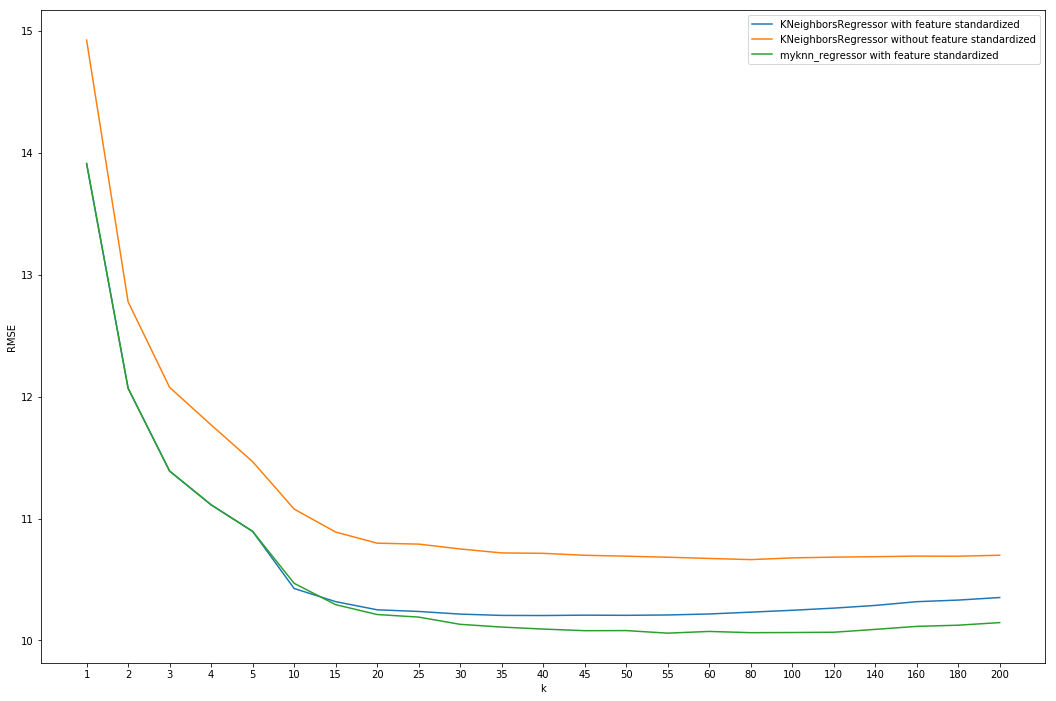

In [10]:
import matplotlib.pyplot as plt
x = np.arange(len(ks))
plt.figure(figsize=(18, 12))
plt.xlabel("k")
plt.ylabel("RMSE")
plt.plot(x, first_case_rmse)
plt.plot(x, second_case_rmse)
plt.plot(x, third_case_rmse)

plt.xticks(x, ks)
plt.legend(['KNeighborsRegressor with feature standardized', 'KNeighborsRegressor without feature standardized', 'myknn_regressor with feature standardized'], loc='upper right')

plt.show()

There are a few things that we can tell from the above plot.
1. As k increases, the perfromance of knn model generally becomes better.
2. Models with standardizd features perform better than those without standardized feature.
3. Removing outliers from selected neighbors can increase the performance.